# Model: WangchanBERTa

In [57]:
!pip freeze

absl-py==2.0.0
accelerate==0.25.0
aiohttp==3.9.1
aiosignal==1.3.1
annotated-types==0.6.0
arrow==1.3.0
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1698341106958/work
astunparse==1.6.3
async-timeout==4.0.3
attrs==23.1.0
boto3==1.33.6
botocore==1.33.6
bravado==11.0.3
bravado-core==6.1.0
cachetools==5.3.2
certifi==2023.11.17
charset-normalizer==3.3.2
click==8.1.7
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1691044910542/work
contourpy==1.2.0
cycler==0.12.1
dacite==1.8.1
datasets==2.15.0
debugpy @ file:///home/conda/feedstock_root/build_artifacts/debugpy_1695534290310/work
decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1641555617451/work
dill==0.3.7
emoji==2.8.0
exceptiongroup @ file:///home/conda/feedstock_root/build_artifacts/exceptiongroup_1700579780973/work
executing @ file:///home/conda/feedstock_root/build_artifacts/executing_1698579936712/work
filelock==3.13.1
flatbuffers==23.5.26
fonttools==4.45.1
fqdn==1.5.1
fro

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import numpy as np
import math
import re
import torch
import json
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

# Raw Data

In [59]:
df = pd.read_csv('../datasets/tscc_v0.1-judgement.csv')
print(len(df))
df.head()

1207


,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,isinternalelement,isintent,isneglect,iscause,isjustify,isexcuse,isguilty,isattempt,isattemptimpossible
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,1,1,-1,1,0,0,1,0,-1
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,-1,-1,-1,-1,-1,-1,0,-1,-1
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,1,1,-1,1,0,0,1,0,-1


# Preprocess

## Filter non-relevant article ids

In [60]:
lawids_df = df['lawids']

lawids = []
for ids in lawids_df:
    lawids.extend(ids.split(','))
lawids_set = set(lawids)
print('# Article IDs (before filtering out): ', len(lawids_set))

''' remove any articles with id <= 106 '''
lawids = list(filter(lambda x: int(x.split('-')[1][:3]) > 106, lawids_set))
print('# Article IDs (after filtering out): ', len(lawids))


# # Select only OFFENCE AGAINST LIFE AND BODY (288 - 300)
# ''' remove any articles with id > 300'''
# lawids = list(filter(lambda x: int(x.split('-')[1][:3]) <= 300, lawids))
# print('# Article IDs (after filtering out (>300)): ', len(lawids))
# '''remove any articles from the list: ['CC-289(3)-00', 'CC-298-00']'''
# lawid_filter_list = ['CC-289(3)-00', 'CC-298-00']
# lawids = list(filter(lambda x: x not in lawid_filter_list, lawids))
# print('# Article IDs (after filtering out (from list)): ', len(lawids))

# Select only OFFENCE AGAINST LIBERTY AND REPUTATION (326 - 333)
# ''' remove any articles with id > 333 or < 326'''
# lawids = list(filter(lambda x: 326 <= int(x.split('-')[1][:3]) <= 333, lawids))
# print('# Article IDs (after filtering out (<326 or > 333)): ', len(lawids))

'''remove articles that appear less than 5 times among all datapoints'''
drop_article_list = ['CC-390-00','CC-289(7)-00', 'CC-339-01', 'CC-342-00', 'CC-338-00', 'CC-335-01', 
                     'CC-335bis-00', 'CC-289(3)-00', 'CC-354-00', 'CC-298-00', 'CC-335bis-01']
lawids = [x for x in lawids if x not in drop_article_list]
print('# Article IDs (after dropping non frequent articles): ', len(lawids))

lawids

# Article IDs (before filtering out):  76
# Article IDs (after filtering out):  50
# Article IDs (after dropping non frequent articles):  39


['CC-297-00',
 'CC-393-00',
 'CC-326-01',
 'CC-335-02',
 'CC-343-00',
 'CC-328-01',
 'CC-328-00',
 'CC-336bis-00',
 'CC-289(6)-00',
 'CC-329-00',
 'CC-352-00',
 'CC-330-00',
 'CC-335-00',
 'CC-360-00',
 'CC-334-00',
 'CC-391-00',
 'CC-295-00',
 'CC-340ter-00',
 'CC-296-00',
 'CC-341-00',
 'CC-339-00',
 'CC-290-00',
 'CC-331-00',
 'CC-340-01',
 'CC-358-00',
 'CC-337-00',
 'CC-326-02',
 'CC-336-00',
 'CC-289(4)-00',
 'CC-340-00',
 'CC-291-00',
 'CC-339-02',
 'CC-326-00',
 'CC-288-00',
 'CC-289(5)-00',
 'CC-328-02',
 'CC-289(2)-00',
 'CC-300-00',
 'CC-393-01']

# id2label, label2id

In [61]:
id2label = {idx:label for idx, label in enumerate(lawids)}
label2id = {str(label):idx for idx, label in enumerate(lawids)}

## Filter \<discr>...\</discr> portion out of fact description

In [62]:
pattern = r'<discr>.*?</discr>'
df['filtered_fact'] = df.fact.apply(lambda x: re.sub(pattern, '', x)).copy()
df.head()

,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,isinternalelement,isintent,isneglect,iscause,isjustify,isexcuse,isguilty,isattempt,isattemptimpossible,filtered_fact
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1,จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,1,1,-1,1,0,0,1,0,-1,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,1,1,-1,1,0,0,1,0,-1,ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,-1,-1,-1,-1,-1,-1,0,-1,-1,ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,1,1,-1,1,0,0,1,0,-1,โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...


## Multi-hot Encoding

In [63]:
def containsLawID(lawids, lawid):
    if lawid in lawids:
        return 1
    else:
        return 0

'''
Add One Column for each LawID to df
'''
for label in lawids:
    df[label] = df.lawids.apply(lambda lawids: containsLawID(lawids, label))
   
'''
Drop column 
'''
df = df[~(df[lawids] == 0).all(axis=1)]
df = df.reset_index(drop=True)
df.head()

,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,...,CC-340-00,CC-291-00,CC-339-02,CC-326-00,CC-288-00,CC-289(5)-00,CC-328-02,CC-289(2)-00,CC-300-00,CC-393-01
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,0,0,0,1,0,0,0,0,0
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,0,0,0,1,0,0,0,0,0
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,...,0,0,0,0,1,0,0,0,0,0
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,...,0,0,0,0,1,0,0,0,0,0


In [64]:
cols = df.columns
label_names = list(cols[20:])
num_labels = len(label_names)
print('num_labels: ', num_labels)
print('Label columns: ', label_names)

num_labels:  39
Label columns:  ['CC-297-00', 'CC-393-00', 'CC-326-01', 'CC-335-02', 'CC-343-00', 'CC-328-01', 'CC-328-00', 'CC-336bis-00', 'CC-289(6)-00', 'CC-329-00', 'CC-352-00', 'CC-330-00', 'CC-335-00', 'CC-360-00', 'CC-334-00', 'CC-391-00', 'CC-295-00', 'CC-340ter-00', 'CC-296-00', 'CC-341-00', 'CC-339-00', 'CC-290-00', 'CC-331-00', 'CC-340-01', 'CC-358-00', 'CC-337-00', 'CC-326-02', 'CC-336-00', 'CC-289(4)-00', 'CC-340-00', 'CC-291-00', 'CC-339-02', 'CC-326-00', 'CC-288-00', 'CC-289(5)-00', 'CC-328-02', 'CC-289(2)-00', 'CC-300-00', 'CC-393-01']


## Stats

In [65]:
print('Count of 1 per label: \n', df[label_names].sum(), '\n')
print('Count of 0 per label: \n', df[label_names].eq(0).sum())


Count of 1 per label: 
 CC-297-00        26
CC-393-00        20
CC-326-01        57
CC-335-02        46
CC-343-00         6
CC-328-01        51
CC-328-00        17
CC-336bis-00     11
CC-289(6)-00      6
CC-329-00       108
CC-352-00        61
CC-330-00        14
CC-335-00         8
CC-360-00         7
CC-334-00        90
CC-391-00        11
CC-295-00        44
CC-340ter-00     10
CC-296-00         5
CC-341-00       183
CC-339-00         6
CC-290-00        20
CC-331-00        11
CC-340-01         9
CC-358-00         8
CC-337-00         8
CC-326-02        26
CC-336-00         7
CC-289(4)-00     48
CC-340-00         5
CC-291-00        18
CC-339-02        15
CC-326-00        61
CC-288-00       221
CC-289(5)-00     10
CC-328-02        40
CC-289(2)-00     13
CC-300-00        13
CC-393-01        27
dtype: int64 

Count of 0 per label: 
 CC-297-00       1158
CC-393-00       1164
CC-326-01       1127
CC-335-02       1138
CC-343-00       1178
CC-328-01       1133
CC-328-00       1167
CC-336bis-

In [66]:
np_labels = list(map(tuple, df[label_names].sum().items()))
np_labels.sort(key=lambda x: x[1], reverse=True)
np_labels

[('CC-288-00', 221),
 ('CC-341-00', 183),
 ('CC-329-00', 108),
 ('CC-334-00', 90),
 ('CC-352-00', 61),
 ('CC-326-00', 61),
 ('CC-326-01', 57),
 ('CC-328-01', 51),
 ('CC-289(4)-00', 48),
 ('CC-335-02', 46),
 ('CC-295-00', 44),
 ('CC-328-02', 40),
 ('CC-393-01', 27),
 ('CC-297-00', 26),
 ('CC-326-02', 26),
 ('CC-393-00', 20),
 ('CC-290-00', 20),
 ('CC-291-00', 18),
 ('CC-328-00', 17),
 ('CC-339-02', 15),
 ('CC-330-00', 14),
 ('CC-289(2)-00', 13),
 ('CC-300-00', 13),
 ('CC-336bis-00', 11),
 ('CC-391-00', 11),
 ('CC-331-00', 11),
 ('CC-340ter-00', 10),
 ('CC-289(5)-00', 10),
 ('CC-340-01', 9),
 ('CC-335-00', 8),
 ('CC-358-00', 8),
 ('CC-337-00', 8),
 ('CC-360-00', 7),
 ('CC-336-00', 7),
 ('CC-343-00', 6),
 ('CC-289(6)-00', 6),
 ('CC-339-00', 6),
 ('CC-296-00', 5),
 ('CC-340-00', 5)]

In [67]:
label2freqord = {x[1][0]: x[0] for x in enumerate(np_labels)}
label2freqord

{'CC-288-00': 0,
 'CC-341-00': 1,
 'CC-329-00': 2,
 'CC-334-00': 3,
 'CC-352-00': 4,
 'CC-326-00': 5,
 'CC-326-01': 6,
 'CC-328-01': 7,
 'CC-289(4)-00': 8,
 'CC-335-02': 9,
 'CC-295-00': 10,
 'CC-328-02': 11,
 'CC-393-01': 12,
 'CC-297-00': 13,
 'CC-326-02': 14,
 'CC-393-00': 15,
 'CC-290-00': 16,
 'CC-291-00': 17,
 'CC-328-00': 18,
 'CC-339-02': 19,
 'CC-330-00': 20,
 'CC-289(2)-00': 21,
 'CC-300-00': 22,
 'CC-336bis-00': 23,
 'CC-391-00': 24,
 'CC-331-00': 25,
 'CC-340ter-00': 26,
 'CC-289(5)-00': 27,
 'CC-340-01': 28,
 'CC-335-00': 29,
 'CC-358-00': 30,
 'CC-337-00': 31,
 'CC-360-00': 32,
 'CC-336-00': 33,
 'CC-343-00': 34,
 'CC-289(6)-00': 35,
 'CC-339-00': 36,
 'CC-296-00': 37,
 'CC-340-00': 38}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


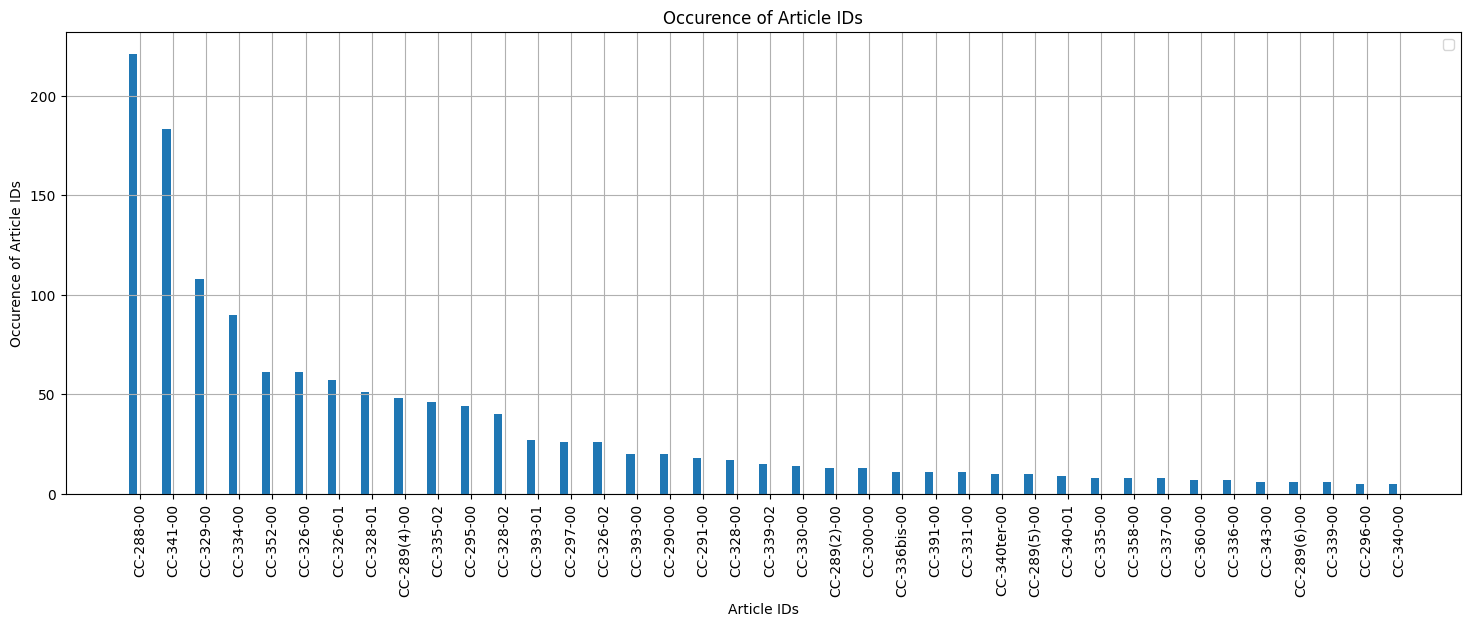

In [68]:
laws, counts = zip(*np_labels)

x = range(len(laws))
x2 = [i + 0.4 for i in x if laws[i] in laws]
width = 0.25

plt.figure(figsize=(18,6))
plt.bar(x, counts, width=width)

x_ticks_labels = [str(lawid) for lawid in laws]
plt.xticks([x + 0.2 for x in x], x_ticks_labels, rotation='vertical')
plt.ylabel('Occurence of Article IDs')
plt.xlabel('Article IDs')
plt.title('Occurence of Article IDs')
plt.grid()
plt.legend()
plt.show()

Number of cases that have more than one label:  155


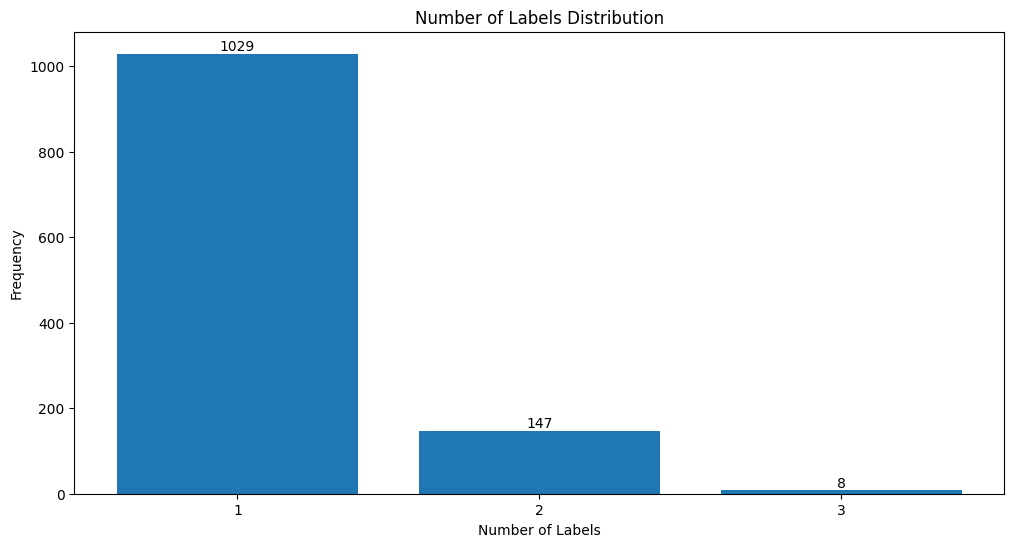

In [69]:
num_more_than_one_label = 0
list_num_labels = []
for i in range(len(df)):
    x = sum([df.loc[i, col] for col in label_names])
    list_num_labels.append(x)
    if x > 1:
        num_more_than_one_label += 1
print('Number of cases that have more than one label: ', num_more_than_one_label)

# np_num_labels = np.array(list_num_labels)
counter_num_labels = Counter(list_num_labels)

plt.figure(figsize=(12,6))
ax = plt.bar(counter_num_labels.keys(), counter_num_labels.values())
plt.xticks([1, 2, 3])
plt.bar_label(ax)
plt.ylabel('Frequency')
plt.xlabel('Number of Labels')
plt.title('Number of Labels Distribution')
plt.show()

## Encode Label

In [70]:
def extract_relevant_labels(case_lawids):
    case_lawids = case_lawids.split(',')
    case_lawids = [lawid for lawid in case_lawids if lawid in lawids]
    return case_lawids

'''
Select one most frequent label for each datapoint
'''
def label_encode(case_lawids):
    case_lawids.sort(key=lambda x: label2freqord[x])
    return label2id[case_lawids[0]]

for label in lawids:
    df['filtered_lawids'] = df.lawids.apply(lambda lawids: extract_relevant_labels(lawids))

df['label'] = df.filtered_lawids.apply(lambda lawids: label_encode(lawids))

## Multi-hot labels (Deprecated)

In [71]:
df['one_hot_labels'] = list(df[label_names].values)
df.head()

,issueid,dekaid,year,category,issueno,lawids,fact,decision,isact,isexternalelements,...,CC-326-00,CC-288-00,CC-289(5)-00,CC-328-02,CC-289(2)-00,CC-300-00,CC-393-01,filtered_lawids,label,one_hot_labels
0,1,1478/2528,2528,LB,1,"CC-288-00,CC-083-00,CC-063-00",จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้...,จำเลยจึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,1,0,0,0,0,0,[CC-288-00],33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1548/2531,2531,LB,1,CC-288-00,จำเลยที่ 1 ซึ่งเคยมีเรื่องทะเลาะกับผู้ตายมาก่อ...,จำเลยที่ 1 จึงมีความผิดฐานฆ่าผู้ตายโดยเจตนา,1,1,...,0,1,0,0,0,0,0,[CC-288-00],33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,1548/2531,2531,LB,2,"CC-290-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,1,1,...,0,0,0,0,0,0,0,[CC-290-00],21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,1548/2531,2531,LB,3,"CC-288-00,CC-083-00",ส่วนจำเลยที่ 2 ที่ 3 และที่ 4 นั้น ได้ความว่าก...,การที่จำเลยที่ 1 ใช้เหล็กแหลมแทงผู้ตายโดยเจตนา...,0,-1,...,0,1,0,0,0,0,0,[CC-288-00],33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,1697/2522,2522,LB,1,"CC-288-00,CC-083-00",โจทก์บรรยายฟ้องว่า จำเลยกับพวกที่ยังไม่ได้ตัวม...,จึงเป็นการกระทำโดยมีเจตนาฆ่าผู้ตาย แม้ข้อเท็จจ...,1,1,...,0,1,0,0,0,0,0,[CC-288-00],33,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [72]:
labels = list(df.label.values)
facts = list(df.filtered_fact.values)
print(len(labels))
print(len(facts))


1184
1184


In [73]:
# num_labels = len(Counter(labels))
# num_labels
len(Counter(labels))

37

In [74]:
sorted(labels, reverse=True)

[38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 38,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,


The number of distinct labels are reduced to 37.

# Create Dataset

## Tokenizer from Model 

In [75]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
# model_name = "xlm-roberta-base"

In [76]:
# Counter([len(tokenizer.tokenize(sent)) for sent in facts])

In [77]:
!pip install transformers
!pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2

In [78]:
!pip freeze | grep sentence

sentencepiece==0.1.99


In [79]:
max_length = 416
tokenizer = AutoTokenizer.from_pretrained(
                model_name,
                revision='main',
                model_max_length=max_length,)

encodings = tokenizer(facts, max_length=max_length, padding=True, truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [80]:
!pip freeze | grep sentence

sentencepiece==0.1.99


In [81]:
type(encodings)

transformers.tokenization_utils_base.BatchEncoding

In [82]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

## Stratifying

In [83]:
label_counts = df.label.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.label.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


Note: There is no label appearing only on one instance.

In [84]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

## Train, Valid Split

In [85]:
# Use train_test_split to split our data into train and validation sets

train_inputs, valid_inputs, train_labels, \
    valid_labels, train_masks, valid_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=101, test_size=0.10, stratify=labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

valid_inputs = torch.tensor(valid_inputs)
valid_labels = torch.tensor(valid_labels)
valid_masks = torch.tensor(valid_masks)

In [86]:
# sorted(valid_labels)

## Dataset Stats

In [87]:
count_train_labels = Counter(map(int, train_labels.tolist())).most_common()
count_valid_labels = Counter(map(int, valid_labels.tolist()))

np_labels_train_valid = [(id2label[id], count, count_valid_labels[id]) for (id, count) in count_train_labels]
len(np_labels_train_valid)

37

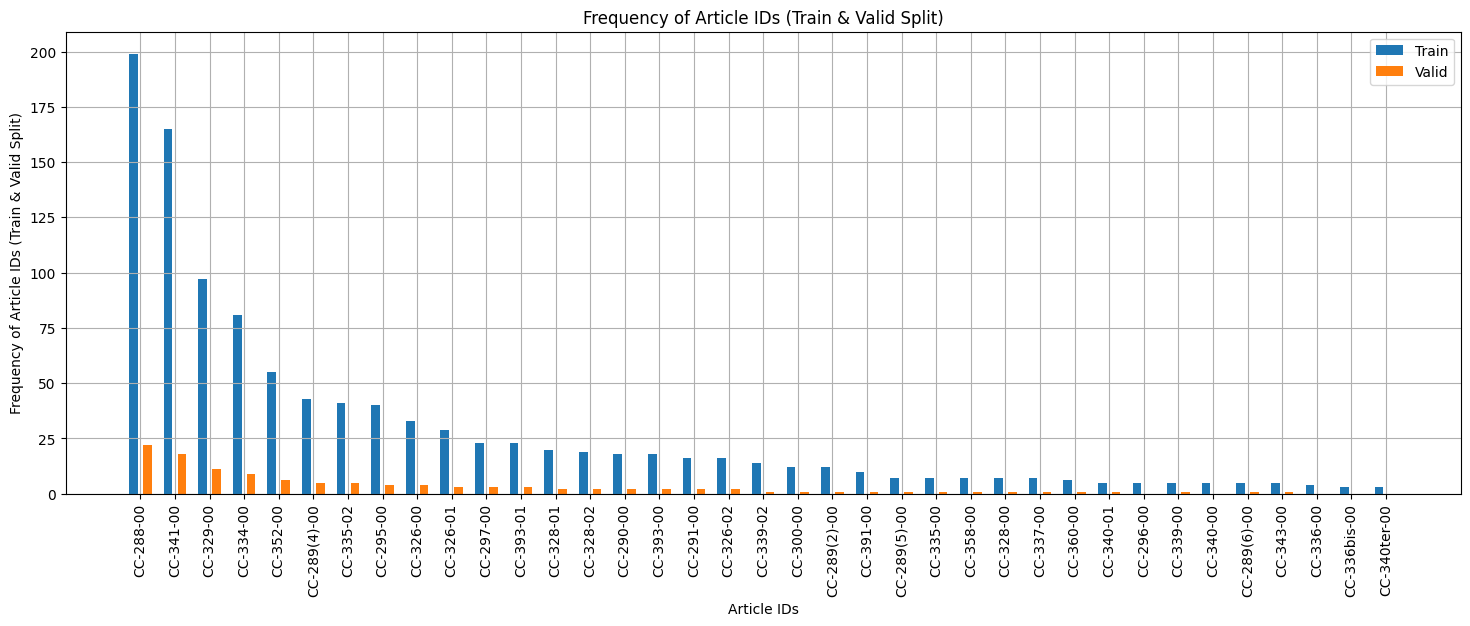

In [88]:
laws, counts_train, counts_valid = zip(*np_labels_train_valid)


x = range(len(laws))
x2 = [i + 0.4 for i in x if laws[i] in laws]
width = 0.25

plt.figure(figsize=(18,6))
plt.bar(x, counts_train, width=width, label='Train')
plt.bar(x2, counts_valid, width=width, label='Valid')

x_ticks_labels = [str(lawid) for lawid in laws]
plt.xticks([x + 0.2 for x in x], x_ticks_labels, rotation='vertical')
plt.ylabel('Frequency of Article IDs (Train & Valid Split)')
plt.xlabel('Article IDs')
plt.title('Frequency of Article IDs (Train & Valid Split)')
plt.grid()
plt.legend()
plt.show()

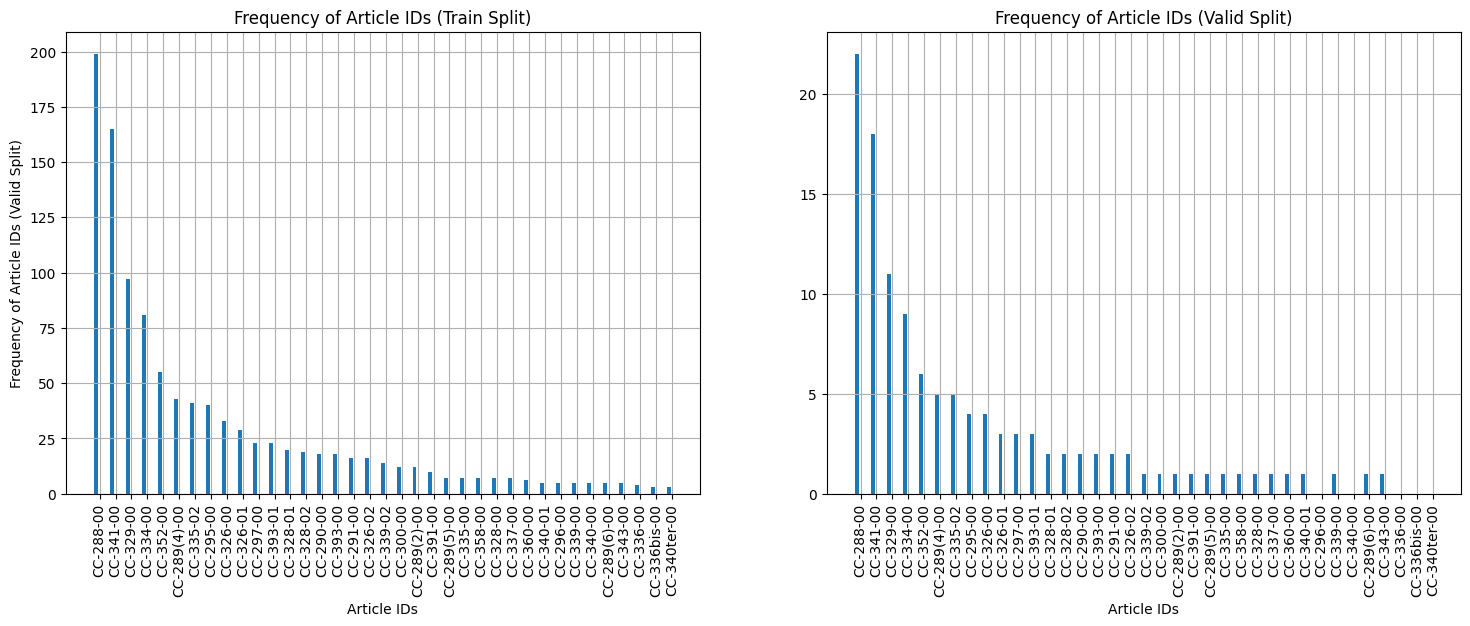

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.bar(x, counts_train, width=width)
ax2.bar(x, counts_valid, width=width)
x_ticks_labels = [str(lawid) for lawid in laws]
ax1.set_xticks([x + 0.2 for x in x], x_ticks_labels, rotation='vertical')
ax2.set_xticks([x + 0.2 for x in x], x_ticks_labels, rotation='vertical')
ax1.set_ylabel('Frequency of Article IDs (Valid Split)')
ax1.set_xlabel('Article IDs')
ax2.set_xlabel('Article IDs')
ax1.set_title('Frequency of Article IDs (Train Split)')
ax2.set_title('Frequency of Article IDs (Valid Split)')
ax1.grid()
ax2.grid()

plt.show()

### Number of labels per datapoints (Deprecated)

In [90]:
# num_labels_train = train_labels.sum(axis=1)
# num_labels_valid = valid_labels.sum(axis=1)

In [91]:
# train_mean_num_label = num_labels_train.mean().item()
# valid_mean_num_label = num_labels_valid.mean().item()
# print('Mean number of labels per data point (Train):', train_mean_num_label)
# print('Mean number of labels per data point (Valid):', valid_mean_num_label)

In [92]:
# list_num_labels_train = list(int(x.item()) for x in num_labels_train)
# list_num_labels_valid = list(int(x.item()) for x in num_labels_valid)

In [93]:
# counter_num_labels_train = Counter(list_num_labels_train)
# counter_num_labels_valid = Counter(list_num_labels_valid)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
# c1 = ax1.bar(counter_num_labels_train.keys(), counter_num_labels_train.values())
# c2 = ax2.bar(counter_num_labels_valid.keys(), counter_num_labels_valid.values())
# x_ticks_labels = [str(lawid) for lawid in laws]
# ax1.set_xticks([1, 2, 3])
# ax2.set_xticks([1, 2, 3])
# ax1.bar_label(c1)
# ax2.bar_label(c2)

# ax1.set_ylabel('Frequency')
# ax1.set_xlabel('Number of Labels')
# ax2.set_xlabel('Number of Labels')
# ax1.set_title('Number of Labels Distribution (Train Split)')
# ax2.set_title('Number of Labels Distribution (Valid Split)')


# plt.show()

## Change to dictionary for Trainer class

In [94]:
class TSCCDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, masks, labels):
        self.inputs = inputs
        self.masks = masks
        self.labels = labels

    def __getitem__(self, idx):
        item = {'input_ids': self.inputs[idx], 'attention_mask': self.masks[idx], 'labels': self.labels[idx]}
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TSCCDataset(train_inputs, train_masks, train_labels)
valid_dataset = TSCCDataset(valid_inputs, valid_masks, valid_labels)

In [95]:
print(train_inputs.shape, train_masks.shape, train_labels.shape)

torch.Size([1065, 416]) torch.Size([1065, 416]) torch.Size([1065])


# Load Model & Set Params

In [96]:
#revision = "finetuned@wisesight_sentiment"
revision = None
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    revision=revision
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [97]:
'''Trying forward pass'''
outputs = model(input_ids=train_dataset[0]['input_ids'].unsqueeze(0), 
    labels=train_dataset[0]['labels'].unsqueeze(0),
    attention_mask=train_dataset[0]['attention_mask'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(4.1053, grad_fn=<NllLossBackward0>), logits=tensor([[-0.1217,  0.3322, -0.0913, -0.0960,  0.1594, -0.0399, -0.5079, -0.2760,
         -0.2397, -0.0181, -0.2032,  0.1085,  0.0547,  0.2478, -0.4450,  0.6898,
          0.3134,  0.0555, -0.3509, -0.4175,  0.0897, -0.2375, -0.0746, -0.2852,
         -0.3820,  0.1407, -0.0050,  0.1059,  0.1273, -0.3377, -0.3198,  0.5024,
         -0.1736,  0.1238, -0.0753,  0.0476, -0.2333, -0.1021,  0.3687]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [98]:
# outputs.logits.shape

In [99]:
outputs = model(input_ids=train_dataset[0]['input_ids'].unsqueeze(0), 
    labels=train_dataset[0]['labels'].unsqueeze(0),
    attention_mask=train_dataset[0]['attention_mask'].unsqueeze(0),
    output_hidden_states = True)
outputs.hidden_states[-1].mean(1).shape

torch.Size([1, 768])

# Train

In [100]:
!pip install neptune
!pip install transformers[torch]

In [101]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, multilabel_confusion_matrix, classification_report
from transformers import EvalPrediction
import torch

from transformers.integrations import NeptuneCallback
import neptune

In [102]:
import os
from getpass import getpass
os.environ["NEPTUNE_API_TOKEN"] = getpass("Enter API token: ")
os.environ["NEPTUNE_PROJECT"] = "kanathip137/wangchanberta-finetuned-relevant-article"

In [103]:
!pip install datasets
!pip install ipywidgets widgetsnbextension pandas-profiling

In [104]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, y_labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = y_labels
    
    # y_pred = y_pred.flatten()
    # y_true = y_true.flatten()
    # print('y_true', y_true.shape)
    # print('y_pred', y_pred.shape)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred, normalize=True)
    confusion_matrix = multilabel_confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=False, target_names=labels)
    # report_sample_wise = classification_report(y_true.T, y_pred.T, output_dict=False, target_names=labels)
    
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'confusion_matrix': confusion_matrix.tolist(),
               'report': report}
    return metrics

def single_label_metrics(predictions, y_labels, threshold=0.5):
    y_pred = predictions.argmax(-1)

    f1_micro_average = f1_score(y_true=y_labels, y_pred=y_pred, average='micro')
    accuracy = accuracy_score(y_true=y_labels, y_pred=y_pred, normalize=True)
    report = classification_report(y_true=y_labels, y_pred=y_pred, output_dict=False)

    metrics = {'f1': f1_micro_average,
               'accuracy': accuracy,
               'report': report}
    return metrics

def compute_metrics(p: EvalPrediction):
    # print(p.label_ids)
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = single_label_metrics(
        predictions=preds, 
        y_labels=p.label_ids)
    return result

In [105]:
batch_size = 32
metric_name = 'f1'

In [106]:
training_args = TrainingArguments(
    output_dir='./wangchanberta-finetuned-relevant-article-pred-single',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=batch_size,  # batch size per device during training
    per_device_eval_batch_size=batch_size,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./wangchanberta-finetuned-relevant-article-pred-single-logs',            # directory for storing logs
    logging_steps=1,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    report_to="neptune",
)

In [107]:
# training_args = TrainingArguments(
#     f"wangchanberta-finetuned-relevant-article-pred-liberty",
#     evaluation_strategy = "epoch",
#     save_strategy = "epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=5,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model=metric_name,
#     #push_to_hub=True,
#     logging_dir='/wangchanberta_finetuned_relevant_article_pred_liberty_logs',
#     logging_steps=1,
# )

In [108]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,        # evaluation dataset
    compute_metrics=compute_metrics,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [109]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [110]:
# trainer.train()

In [111]:
len(lawids)                         

39

In [112]:
result_eval = trainer.evaluate()
result_eval

/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs

NeptuneInvalidApiTokenException: 
[95m
----NeptuneInvalidApiTokenException------------------------------------------------
[0m
The provided API token is invalid.
Make sure you copied and provided your API token correctly.

You can get it or check if it is correct here:
    - https://app.neptune.ai/get_my_api_token

There are two options to add it:
    - specify it in your code
    - set it as an environment variable in your operating system.

[94mCODE[0m
Pass the token to the [1minit_run()[0m function via the [1mapi_token[0m argument:
    [96mneptune.init_run(project='WORKSPACE_NAME/PROJECT_NAME', api_token='YOUR_API_TOKEN')[0m

[94mENVIRONMENT VARIABLE[0m [92m(Recommended option)[0m
or export or set an environment variable depending on your operating system:

    [92mLinux/Unix[0m
    In your terminal run:
        [95mexport NEPTUNE_API_TOKEN="YOUR_API_TOKEN"[0m

    [92mWindows[0m
    In your CMD run:
        [95mset NEPTUNE_API_TOKEN="YOUR_API_TOKEN"[0m

and skip the [1mapi_token[0m argument of the [1minit_run()[0m function:
    [96mneptune.init_run(project='WORKSPACE_NAME/PROJECT_NAME')[0m

You may also want to check the following docs page:
    - https://docs.neptune.ai/setup/setting_api_token/

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help


In [ ]:
# # [[TN, FP], [FN, TP]]
# result_eval['eval_confusion_matrix']

In [113]:
–print(result_eval['eval_report'])

SyntaxError: invalid character '–' (U+2013) (3556183839.py, line 1)

eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZDIyNDdmMi05YTY3LTRmYTktODk3OC05ZmMxZmU1NmUxMjAifQ==

In [ ]:
save_path = "./models/wangchanberta-finetuned-relevant-article-pred-single/1"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('./models/wangchanberta-finetuned-relevant-article-pred-single/1/tokenizer_config.json',
 './models/wangchanberta-finetuned-relevant-article-pred-single/1/special_tokens_map.json',
 './models/wangchanberta-finetuned-relevant-article-pred-single/1/sentencepiece.bpe.model',
 './models/wangchanberta-finetuned-relevant-article-pred-single/1/added_tokens.json',
 './models/wangchanberta-finetuned-relevant-article-pred-single/1/tokenizer.json')

# Inference

In [ ]:
text = "จำเลยกับพวกร่วมกันใช้อาวุธปืนยิงผู้ตายถูกที่ด้านหลัง กระสุนปืนตัดบริเวณไขสันหลังขาด ผู้ตายเป็นอัมพาตตั้งแต่เอวจนจดเท้าและถึงแก่ความตายสืบเนื่องมาจากบาดแผลที่ถูกยิงและภาวะติดเชื้ออย่างรุนแรงหลังจากเกิดเหตุ 9 เดือนเศษ"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)
logits = outputs.logits
logits.shape

torch.Size([1, 39])

In [ ]:
# # apply sigmoid + threshold
# sigmoid = torch.nn.Sigmoid()
# probs = sigmoid(logits.squeeze().cpu())
# predictions = np.zeros(probs.shape)
# predictions[np.where(probs >= 0.5)] = 1
# # turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
# print(predicted_labels)

In [ ]:
# apply sigmoid + threshold
id2label[logits.argmax(-1).item()]

'CC-331-00'

# GZIP

In [114]:
from npc_gzip.compressors.base import BaseCompressor
from npc_gzip.compressors.gzip_compressor import GZipCompressor
from npc_gzip.knn_classifier import KnnClassifier

In [115]:
!pip install torchtext
!pip install portalocker>=2.0.0

## Dataset

In [116]:
input_texts = df['filtered_fact'].tolist()

In [117]:
train_text_inputs, valid_text_inputs, \
    train_labels, valid_labels = train_test_split(input_texts, labels, random_state=101, 
                                                  test_size=0.10, stratify=labels)

In [118]:
compressor = GZipCompressor()
gzip_model = KnnClassifier(
    compressor=compressor,
    training_inputs=train_text_inputs,
    training_labels=train_labels,
    distance_metric='ncd'
)

## Evaluation

In [119]:
top_k = 1

distances, pred, similar_samples = gzip_model.predict(
    valid_text_inputs, top_k, sampling_percentage=1.0
)

print(classification_report(valid_labels, pred.reshape(-1)))

Compressing input...:   0%|          | 0/119 [00:00<?, ?it/s]

Compressing input...: 100%|██████████| 119/119 [00:12<00:00,  9.17it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.17      0.20      0.18         5
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.46      0.55      0.50        11
          10       0.14      0.17      0.15         6
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.20      0.22      0.21         9
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         4
          18       0.00      0.00      0.00         0
          19       0.55      0.61      0.58        18
          20       0.00    


/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/env

# References

- WangchanBERTa Tutorial: https://colab.research.google.com/drive/1Kbk6sBspZLwcnOE61adAQo30xxqOQ9ko

- Slightly oudated multilabel classification using HuggingFace's Transformer: https://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1

- Another multilabel classification examples: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

- GZip (npc_gzip): https://github.com/bazingagin/npc_gzip/blob/main/examples/imdb.py